# Multilayer Perceptron

In [1]:
import pandas as pd
import random as rd
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats

import utils

## Base Line

In [2]:
# Load data
train_input, train_output = utils.loadTrainingData(remove_id=True, remove_capuchon_insertion=True)
X_train, X_test, y_train, y_test = utils.splitTrain(train_input, train_output)
X_train, X_test = utils.scaleInputData(X_train, X_test)

# Create model
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=400)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Evaluation
metrics.accuracy_score(y_test, y_pred)

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9911154031868662

/home/fabien/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


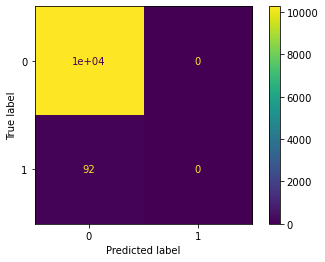

In [3]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

Once again: overfitting due to unbalanced classes !

## Balanced Classes

### Remove Individuals

Iteration 1, loss = 0.69598729
Validation score: 0.571429
Iteration 2, loss = 0.67830694
Validation score: 0.530612
Iteration 3, loss = 0.66704203
Validation score: 0.571429
Iteration 4, loss = 0.66172681
Validation score: 0.571429
Iteration 5, loss = 0.65906828
Validation score: 0.551020
Iteration 6, loss = 0.65594708
Validation score: 0.591837
Iteration 7, loss = 0.65473746
Validation score: 0.591837
Iteration 8, loss = 0.65239543
Validation score: 0.591837
Iteration 9, loss = 0.65074455
Validation score: 0.612245
Iteration 10, loss = 0.65062606
Validation score: 0.612245
Iteration 11, loss = 0.64938284
Validation score: 0.591837
Iteration 12, loss = 0.64886737
Validation score: 0.632653
Iteration 13, loss = 0.64831122
Validation score: 0.612245
Iteration 14, loss = 0.64819926
Validation score: 0.632653
Iteration 15, loss = 0.64635628
Validation score: 0.612245
Iteration 16, loss = 0.64635965
Validation score: 0.591837
Iteration 17, loss = 0.64594224
Validation score: 0.632653
Iterat

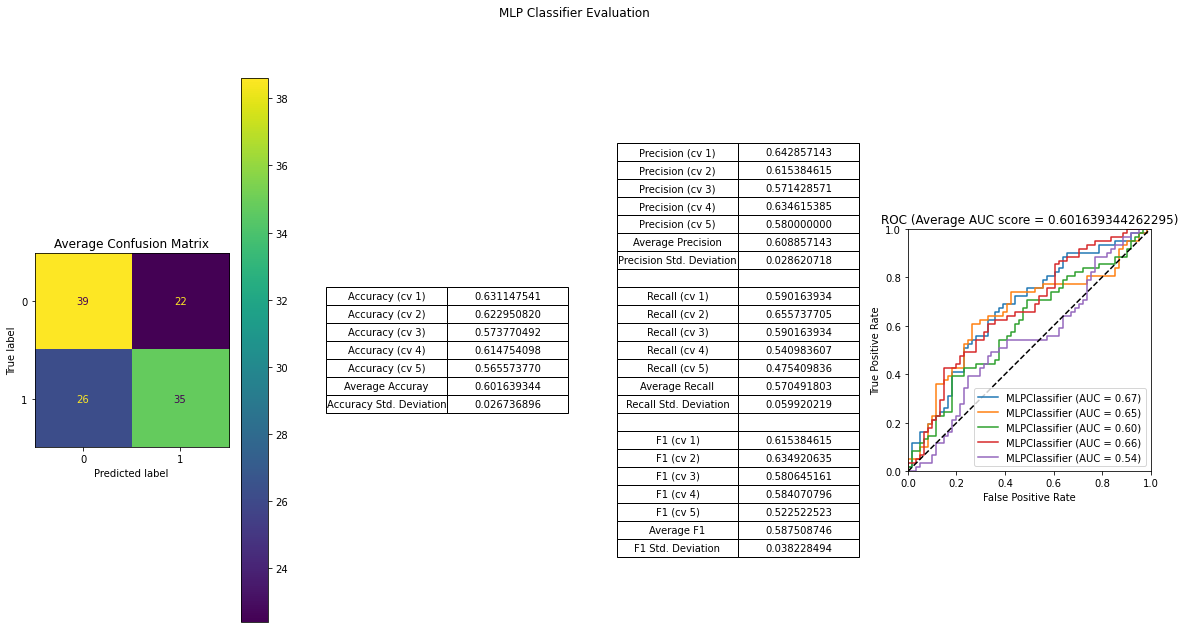

In [4]:
# Load date and balance classes
train_input, train_output = utils.loadTrainingData(remove_id=True, remove_capuchon_insertion=True)
train_input, train_output = utils.balanceClassesByRemoving(train_input, train_output)

# Create model
clf = MLPClassifier(
    solver='sgd',
    activation='tanh', 
    alpha=1e-3,
    batch_size=32,
    learning_rate='adaptive', 
    hidden_layer_sizes=(200,150,100,50), 
    random_state=1, 
    n_iter_no_change =12,
    early_stopping=True,
    max_iter=2000,
    verbose = True)

# Evaluation
utils.modelEvaluation(clf, train_input, train_output, balance_classes=False, scale_data=True, model_name="MLP Classifier", fig_name="mlp_r")

More realistic...

### Duplicate Individuals

Iteration 1, loss = 0.65992798
Validation score: 0.641578
Iteration 2, loss = 0.65083371
Validation score: 0.644867
Iteration 3, loss = 0.64719146
Validation score: 0.647607
Iteration 4, loss = 0.64330314
Validation score: 0.655280
Iteration 5, loss = 0.63916177
Validation score: 0.668067
Iteration 6, loss = 0.63460128
Validation score: 0.656193
Iteration 7, loss = 0.62951482
Validation score: 0.667336
Iteration 8, loss = 0.62378170
Validation score: 0.672269
Iteration 9, loss = 0.61753569
Validation score: 0.676471
Iteration 10, loss = 0.61062892
Validation score: 0.681038
Iteration 11, loss = 0.60375113
Validation score: 0.688345
Iteration 12, loss = 0.59602662
Validation score: 0.686701
Iteration 13, loss = 0.58810202
Validation score: 0.702959
Iteration 14, loss = 0.57939464
Validation score: 0.710632
Iteration 15, loss = 0.57041124
Validation score: 0.709536
Iteration 16, loss = 0.56191698
Validation score: 0.716661
Iteration 17, loss = 0.55220405
Validation score: 0.725612
Iterat

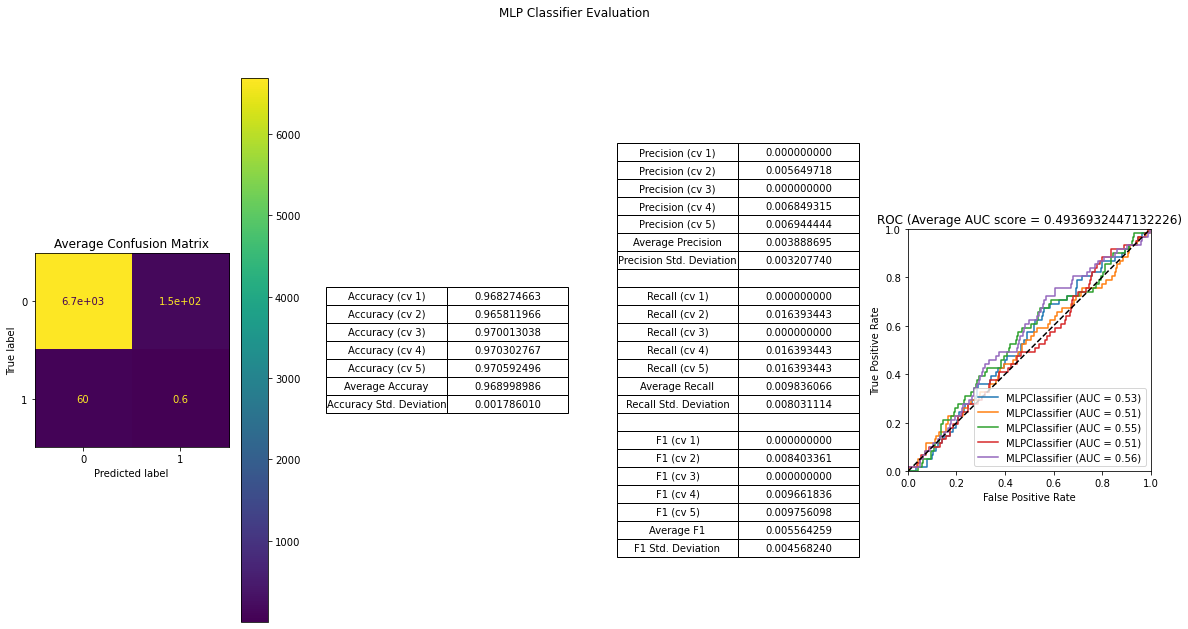

In [5]:
# Load date and balance classes
train_input, train_output = utils.loadTrainingData(remove_id=True, remove_capuchon_insertion=True)

# Create model
clf = MLPClassifier(
    solver='sgd',
    activation='tanh', 
    alpha=1e-3,
    batch_size=128,
    learning_rate='adaptive', 
    hidden_layer_sizes=(200,150,100,50), 
    random_state=1, 
    n_iter_no_change=6,
    tol=1e-3,
    early_stopping=True,
    max_iter=2000,
    verbose=True)

# Evaluation
utils.modelEvaluation(clf, train_input, train_output, balance_classes=True, scale_data=True, model_name="MLP Classifier", fig_name="mlp_d")

## Remove Outliers

In [6]:
# # Copy dataset
# train_input_remove = train_input.copy()
# train_output_remove = train_output.copy()

# # Scale data (MLP is very sensitive to scaling and allow for a unique treshold)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# # Remove outliers
# threshold = 3
# outliers = np.array([], dtype = int)
# for col_name in list(input_header.values())[1:]:
#     z = np.abs(stats.zscore(train_input[col_name]))
#     outliers = np.append(outliers, np.where(z > threshold))
# outliers_no_duplicate = np.array([], dtype=int)
# for i in range(np.size(outliers)):
#     if(outliers[i] not in outliers_no_duplicate):
#         outliers_no_duplicate = np.append(outliers_no_duplicate, outliers[i])
# # np.size(outliers_no_duplicate)

# # Select index
# defect_index = train_output.index[train_output["result"] == 1].tolist()
# for elmt in defect_index:
#     if elmt in outliers_no_duplicate:
#         defect_index.remove(elmt)
# valid_index = train_output.index[train_output["result"] == 0].tolist()
# for elmt in valid_index:
#     if elmt in outliers_no_duplicate:
#         valid_index.remove(elmt)

# # Randomly remove some valid individuals
# rd.shuffle(valid_index) # Shuffle in order to eliminate "production correlation"
# train_input_remove = train_input_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]
# train_output_remove = train_output_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]

# # Create new datasets
# train_input_remove = train_input_remove[train_input_remove.columns[~train_input_remove.columns.isin(["id", "capuchon_insertion"])]]
# X_train, X_test, y_train, y_test = train_test_split(train_input_remove, train_output_remove["result"], test_size = 0.3, random_state = 123)


# # Create model
# mlp_balanced_model = MLPClassifier(
#     solver='sgd',
#     activation='tanh', 
#     alpha=1e-2,
#     batch_size=32,
#     learning_rate='adaptive', 
#     hidden_layer_sizes=(200,150,100,50), 
#     random_state=1, 
#     n_iter_no_change =12,
#     early_stopping=True,
#     max_iter=2000,
#     verbose = False)
# mlp_balanced_model.fit(X_train.values, y_train.values)

# # Prediction
# y_pred = mlp_balanced_model.predict(X_test.values)

# # Evaluation
# metrics.accuracy_score(y_test, y_pred)